# 毕业论文`GRAD`
## `MCIP`气象场分析

---
*@author: Evan*\
*@date: 2023-11-01*

In [1]:
import os
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rcParams
config = {
    "font.family":'Times New Roman',
    "mathtext.fontset":'stix',
    "font.serif": ['SimSun'],
}
rcParams.update(config)

import sys
sys.path.append('../../src/')
from namelist import *
from mask import polygon_to_mask, average_data

# silence the warning note
import warnings
warnings.filterwarnings("ignore")

## 计算平均值数组

In [2]:
var = 'SFC_TMP'
month = "Sep"

low_years = np.array([2016,2015,2014]) # 此处年份倒置是为了方便后续创建dataarray时取用时间维度
high_years = np.array([2022,2021,2019])

low_files  = [os.path.join(processed_dir, f"{month}_{year}/{month}_{year}_mcip.nc") for year in low_years]
high_files = [os.path.join(processed_dir, f"{month}_{year}/{month}_{year}_mcip.nc") for year in high_years]
low_files

['D:/data/Graduation/processed/Sep_2016/Sep_2016_mcip.nc',
 'D:/data/Graduation/processed/Sep_2015/Sep_2015_mcip.nc',
 'D:/data/Graduation/processed/Sep_2014/Sep_2014_mcip.nc']

In [3]:
avg_low  = average_data(low_files, var)
avg_high = average_data(high_files, var)

## 计算珠三角范围平均

In [8]:
shp = gpd.read_file(shpPRD)
lon = avg_low.longitude
lat = avg_low.latitude

mask    = polygon_to_mask(shp.geometry[0], lon, lat)
mask_da = xr.DataArray(mask, dims=('y','x'))

masked_low  = avg_low.where(mask_da)
mean_low    = masked_low.mean(dim=('x','y'),skipna=True)
masked_high = avg_high.where(mask_da)
mean_high   = masked_high.mean(dim=('x','y'),skipna=True)

# 创建掩码，过滤掉无穷大值
# inf_mask  = np.isfinite(mean_low)
# mean_low  = mean_low.where(inf_mask)
# inf_mask  = np.isfinite(mean_high)
# mean_high = mean_high.where(inf_mask)

In [9]:
# mean, max, min
mean_low_day = mean_low.resample(time='D').mean(skipna=True)
max_low_day  = mean_low.resample(time='D').max(skipna=True)
min_low_day  = mean_low.resample(time='D').min(skipna=True)
# percentile
low_80per = mean_low.resample(time='D').quantile(0.8,skipna=True)
low_20per = mean_low.resample(time='D').quantile(0.2,skipna=True)

# mean, max, min
mean_high_day = mean_high.resample(time='D').mean(skipna=True)
max_high_day  = mean_high.resample(time='D').max(skipna=True)
min_high_day  = mean_high.resample(time='D').min(skipna=True)
# percentile
high_80per = mean_high.resample(time='D').quantile(0.8,skipna=True)
high_20per = mean_high.resample(time='D').quantile(0.2,skipna=True)

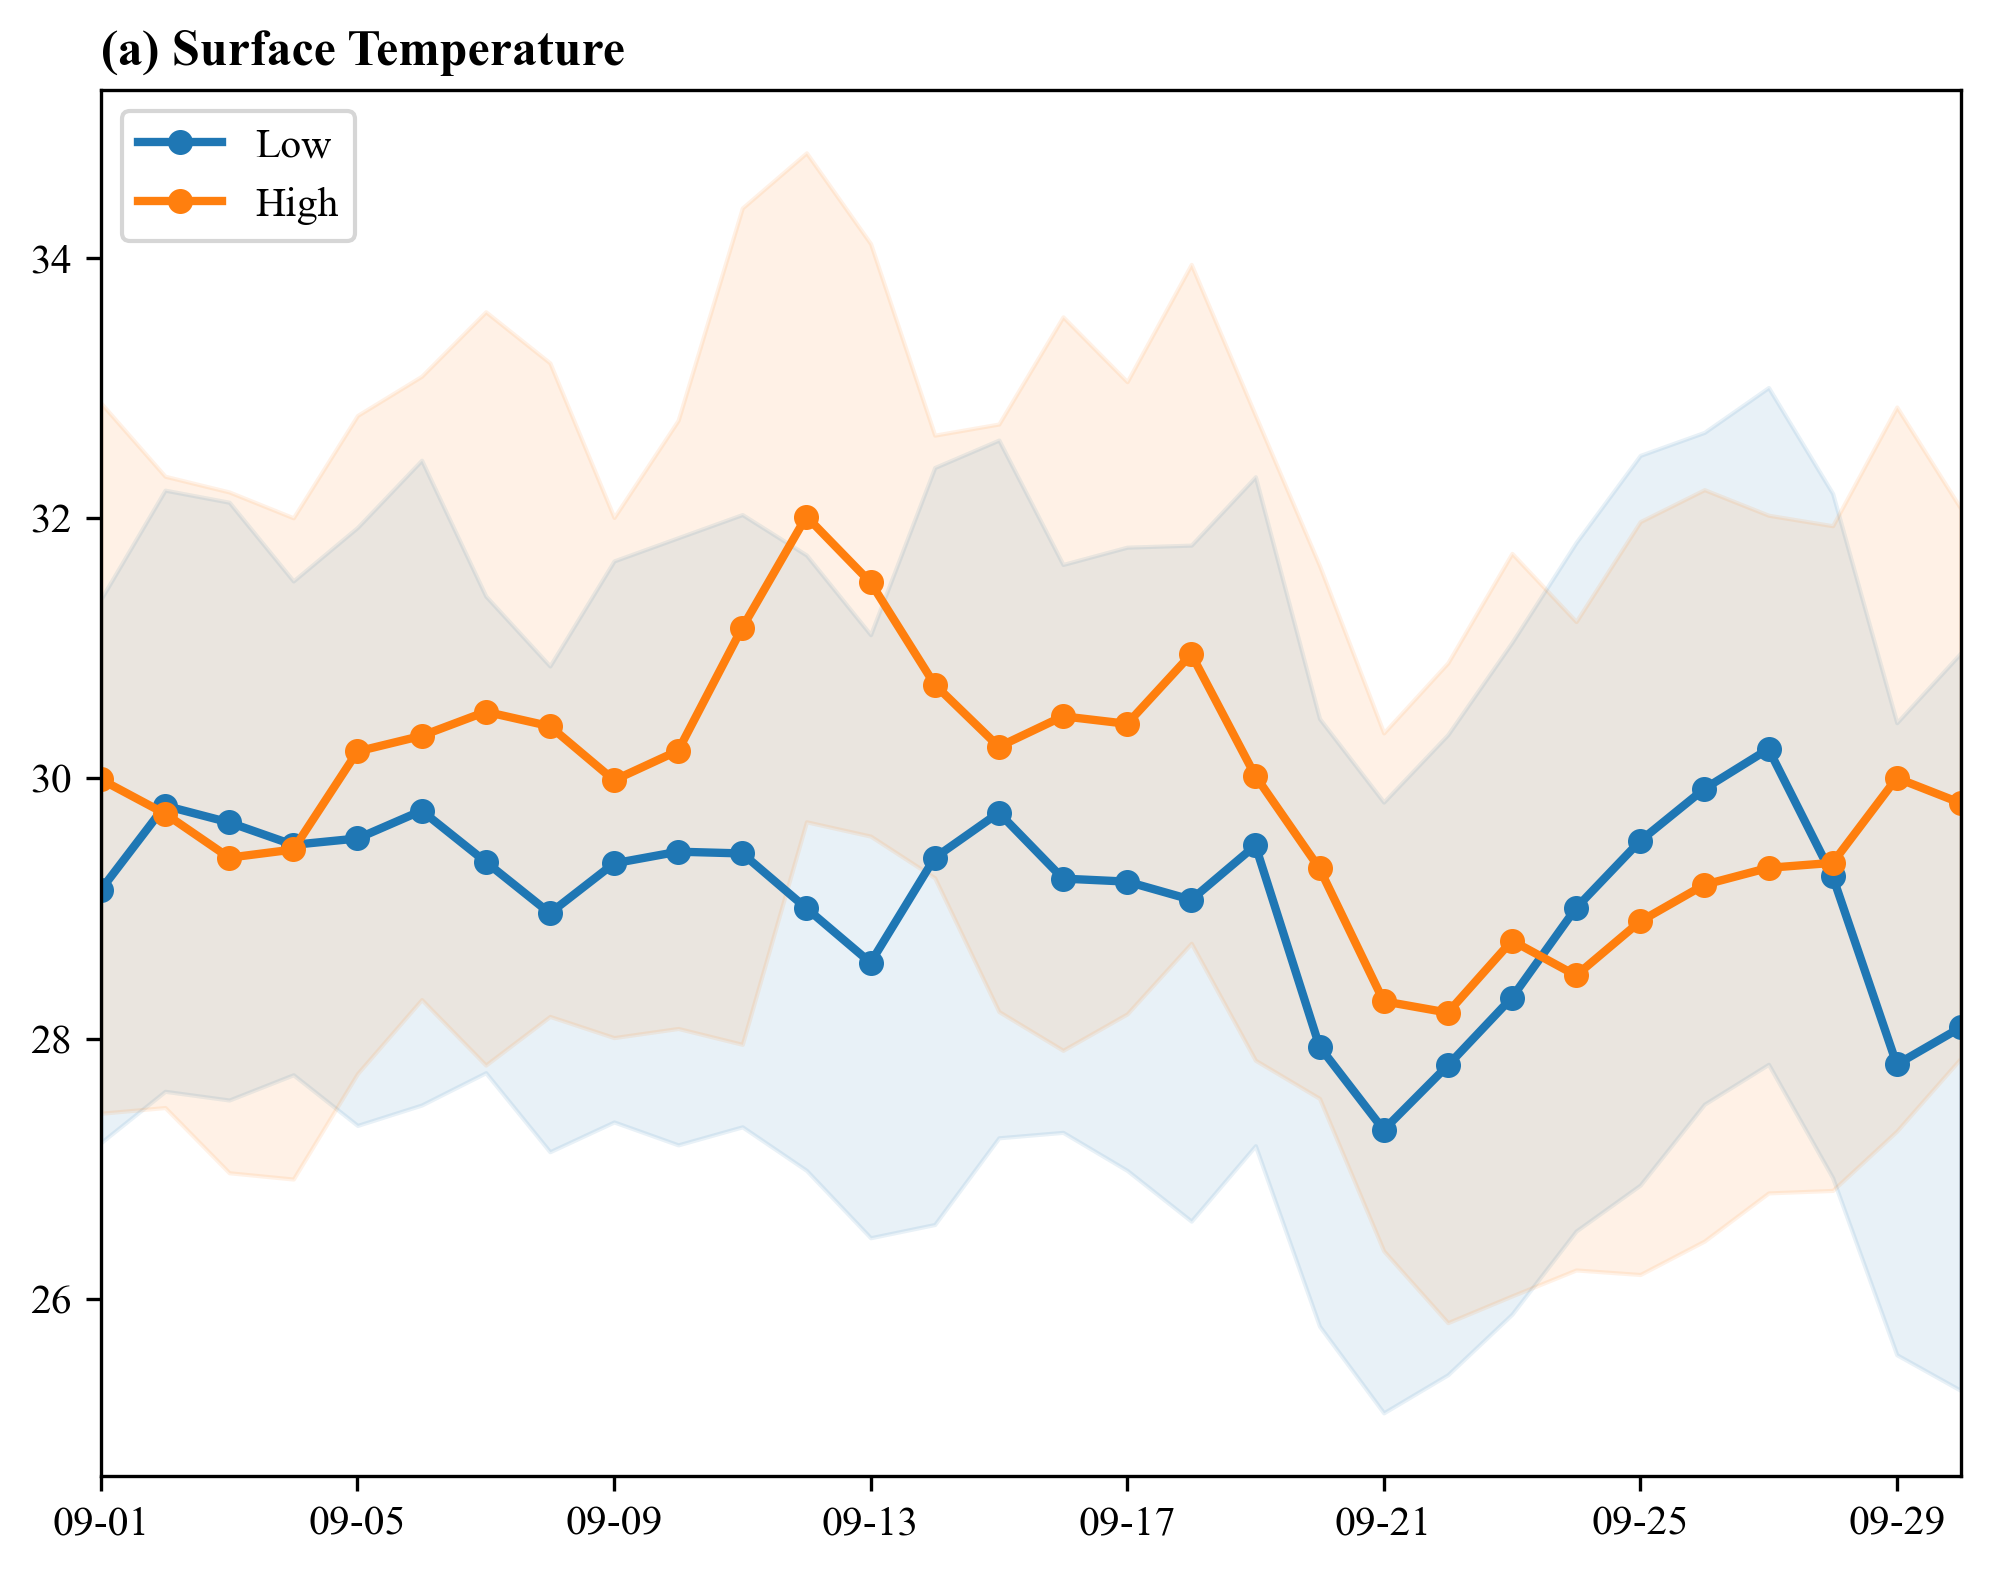

In [10]:
fig = plt.figure(figsize=(8,6),dpi=300)
ax = fig.subplots(1,1)

xx = np.arange(0,len(mean_low_day.time),1)
# lower years
ax.plot(xx,mean_low_day,color='tab:blue',linewidth=2,label='Low',marker='.',markersize=10)
ax.fill_between(xx,low_80per,low_20per,color='tab:blue',alpha=0.1)
# ax.fill_between(xx,max_low_day,min_low_day,color='tab:blue',alpha=0.1)

ax.plot(xx,mean_high_day,color='tab:orange',linewidth=2,label='High',marker='.',markersize=10)
ax.fill_between(xx,high_80per,high_20per,color='tab:orange',alpha=0.1)#,label='20%~80%')
# ax.fill_between(xx,max_high_day,min_high_day,color='tab:orange',alpha=0.1)

# ticks and labels
ax.set_xlim([0,len(mean_low_day.time)-1])
# ax.set_ylim(24,37)
ax.set_xticks(xx[::4])
ax.set_xticklabels(pd.date_range('2023-09-01','2023-09-30',freq='4D').strftime('%m-%d'))#,rotation=45)
ax.legend(loc=2)
ax.set_title('(a) Surface Temperature',loc='left',fontdict={'fontsize':12,'fontweight':'bold'})
plt.show()

### 拼图

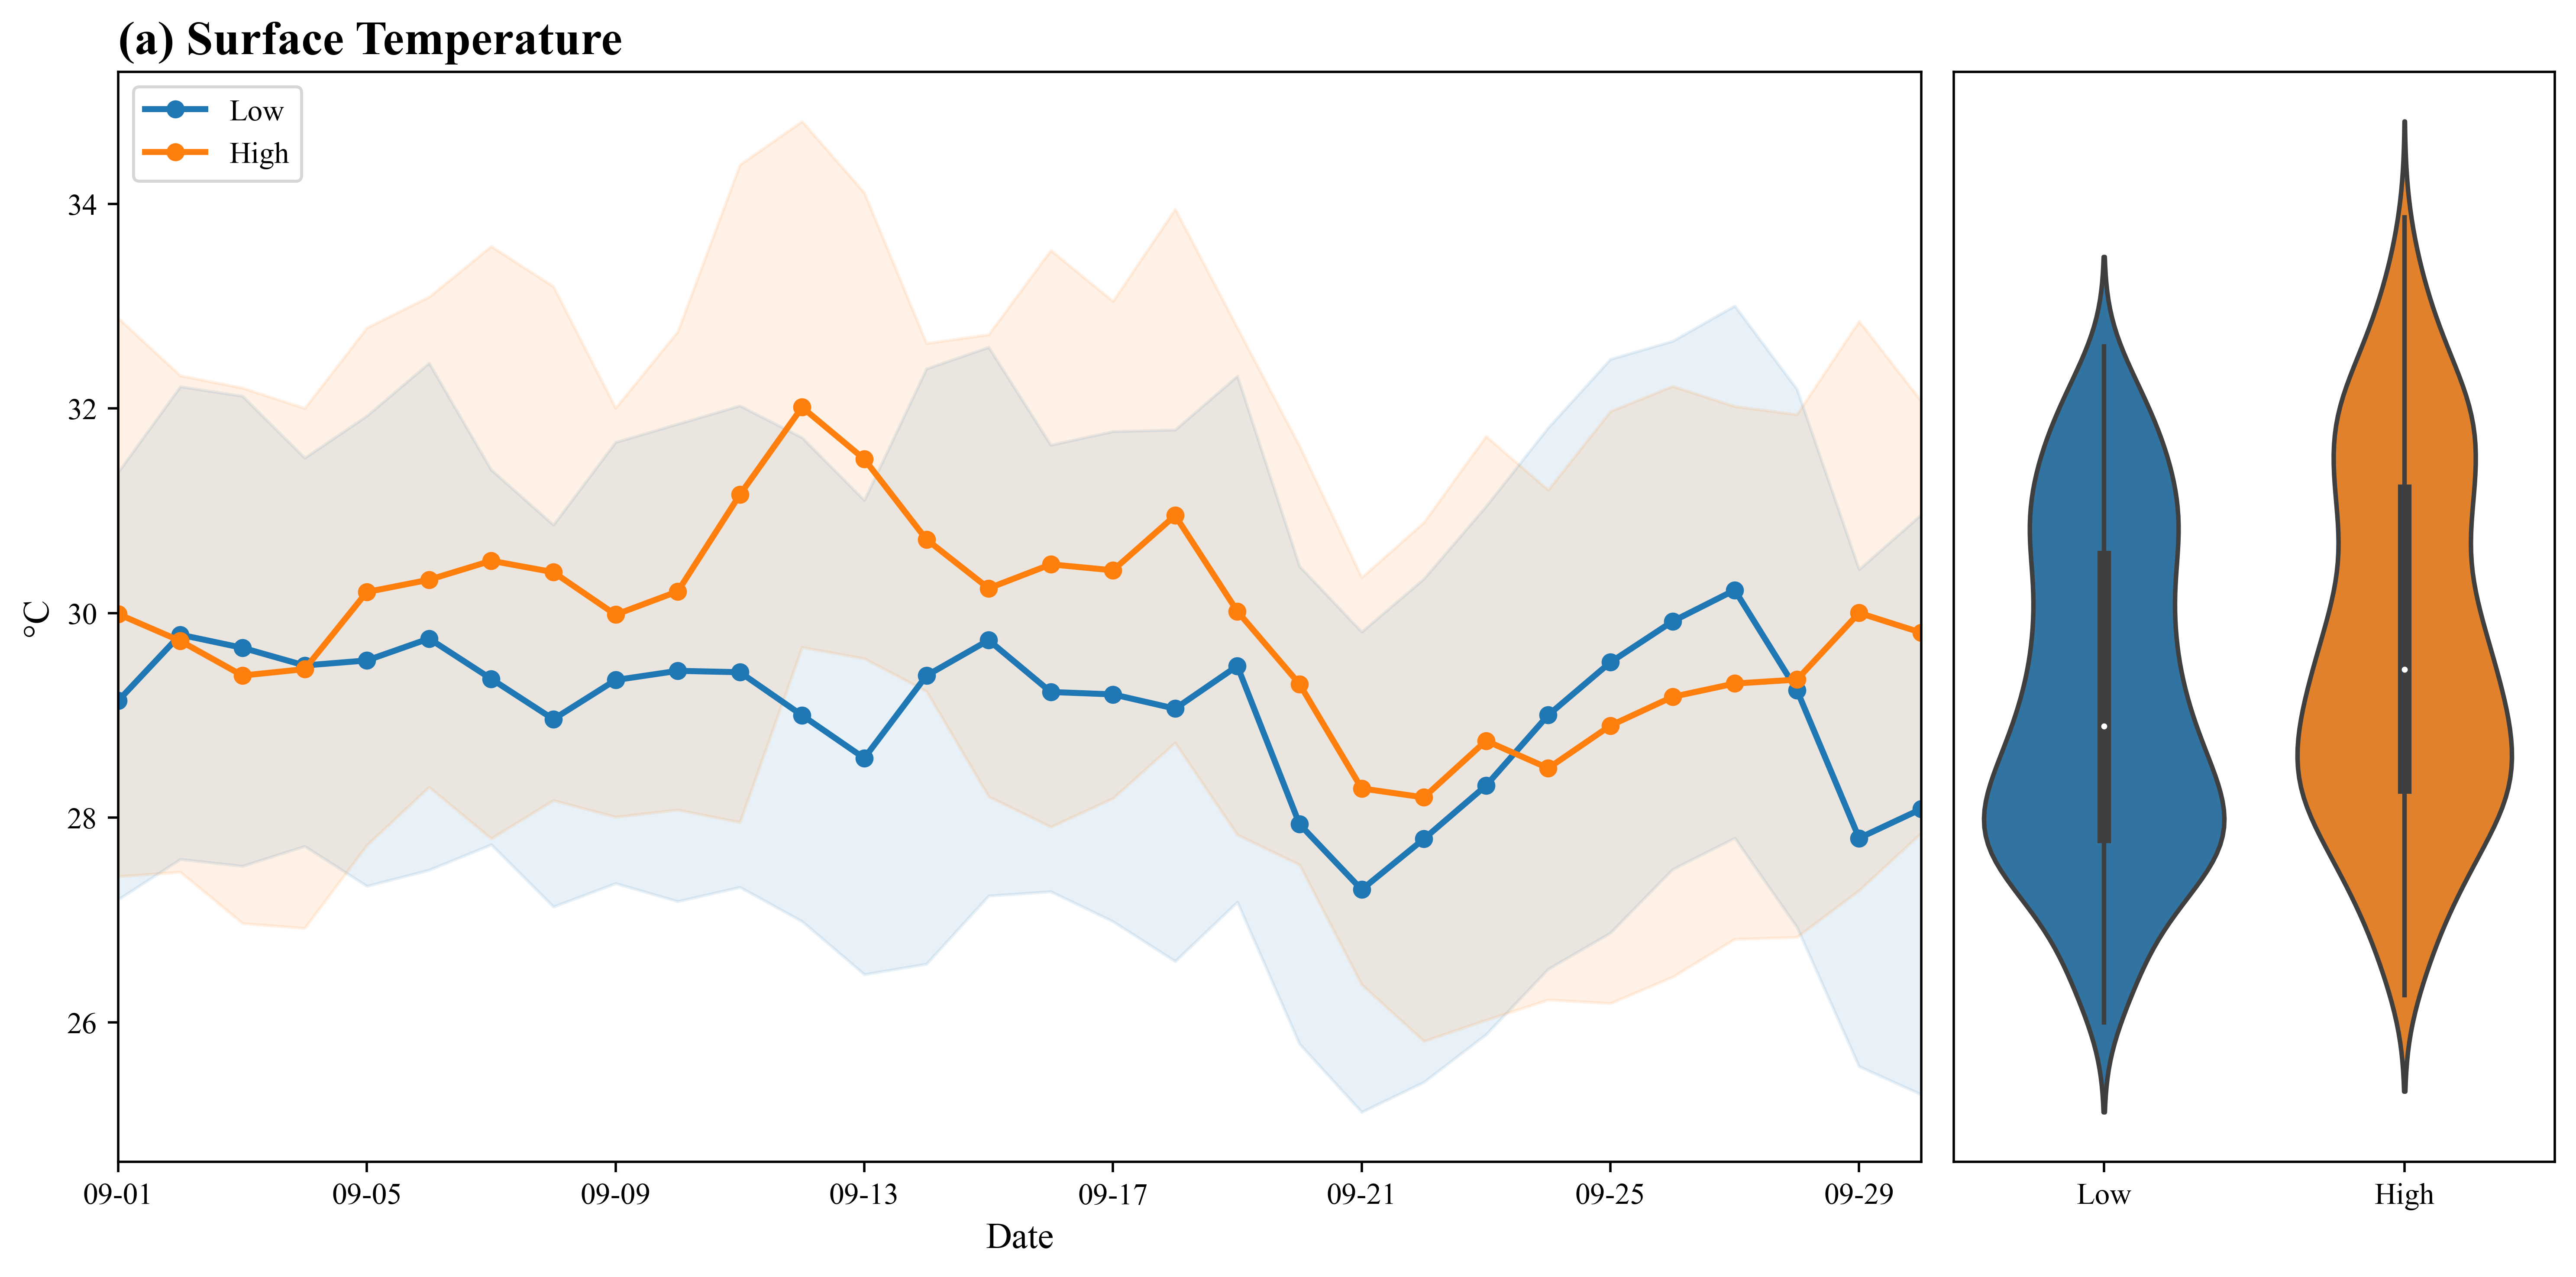

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), dpi=500, gridspec_kw={'width_ratios': [3, 1]})

xx = np.arange(0, len(mean_low_day.time), 1)
# lower years
ax1.plot(xx, mean_low_day, color='tab:blue', linewidth=2, label='Low', marker='.', markersize=10)
ax1.fill_between(xx, low_80per, low_20per, color='tab:blue', alpha=0.1)

ax1.plot(xx, mean_high_day, color='tab:orange', linewidth=2, label='High', marker='.', markersize=10)
ax1.fill_between(xx, high_80per, high_20per, color='tab:orange', alpha=0.1)

# ticks and labels
ax1.set_xlim([0, len(mean_low_day.time) - 1])
ax1.set_xticks(xx[::4])
ax1.set_xticklabels(pd.date_range('2023-09-01', '2023-09-30', freq='4D').strftime('%m-%d'))
ax1.set_xlabel('Date',fontsize=12)
ax1.set_ylabel('°C',fontsize=12)
ax1.legend(loc=2)
ax1.set_title('(a) Surface Temperature', loc='left', fontdict={'fontsize': 16, 'fontweight': 'bold'})

# 图2：小提琴图
df_box = pd.DataFrame({'Low': mean_low.values, 'High': mean_high.values})

color_palette = sns.color_palette(["tab:blue", "tab:orange"])
sns.violinplot(data=df_box, palette=color_palette, ax=ax2)

ax2.set_yticks([])

plt.tight_layout()
plt.show()